In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot as plt
from  GrandPrix import GrandPrix

In [2]:
Y = pd.read_csv('../data/Windram/WindramTrainingData.csv', index_col=[0]).T.values
Y =preprocessing.scale(Y)
mData = pd.read_csv('../data/Windram/WindramMetaData.csv', index_col=[0])

In [3]:
N, D = Y.shape
print('Time Points: %s, Genes: %s'%(N, D))

Time Points: 24, Genes: 100


In [4]:
actual_capture_time = mData['capture.orig'].values
np.random.seed(10)
sigma_t = 3.
prior_mean = mData['capture'].values[:, None]

X_mean = [prior_mean[i, 0] + sigma_t * np.random.randn(1) for i in range(0, N)] 

## RBF Kernel

In [5]:
pseudotime_rbf, var_rbf = GrandPrix.fit_model(Y, latent_prior_mean=prior_mean, latent_prior_var=np.square(sigma_t),
                             latent_mean=np.asarray(X_mean.copy()), latent_var=0.1,
                             kernel={'name':'RBF', 'ls':18.0, 'var':1.0}, 
                             fix_parameters=['kernel_lengthscales','kernel_variance'], display=True)
np.mean(np.sqrt(var_rbf))

sumon
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2661.603958
  Number of iterations: 126
  Number of functions evaluations: 144


0.9161640296116017

### DeLorean ADVI with RBF kernel

In [6]:
VB_rbf = pd.read_csv('../data/Windram/DeLorean_samples/RBF/WindreamDeLoreanSamples_VB_RBF.csv', index_col=0)
# VB_rbf.shape
var_VB_rbf = VB_rbf.groupby('capture.orig')['tau'].var()
np.mean(np.sqrt(var_VB_rbf))

0.5361033666404699

In [7]:
VB_rbf_best = pd.read_csv('../data/Windram/DeLorean_samples/RBF/WindreamDeLoreanBestSample_VB_RBF.csv', index_col=0)

### DeLorean MCM with RBF kernel

In [8]:
MCMC_rbf = pd.read_csv('../data/Windram/DeLorean_samples/RBF/WindreamDeLoreanSamplesMCMC_MultipleChains_RBF.csv', index_col=0)

In [9]:
ncores = 3
MCMCStdEstimatesPerChain_rbf = np.zeros((N, ncores))
for i in range(N):
    idx = MCMC_rbf.columns.str.contains('tau.%g.'%(i+1), regex=False)
    assert idx.sum() == ncores, 'should be %g chains per cell' % ncores
    MCMCStdEstimatesPerChain_rbf[i, :] = np.std(MCMC_rbf.iloc[:,idx], 0)
MCMCStdOnChains_rbf = np.mean(MCMCStdEstimatesPerChain_rbf, 1)
np.mean(MCMCStdOnChains_rbf)

0.9788985543212486

In [10]:
MCMC_rbf_best = pd.read_csv('../data/Windram/DeLorean_samples/RBF/WindreamDeLoreanBestSampleMCMC_RBF.csv', index_col=0)

Text(0,0.5,'Capture time')

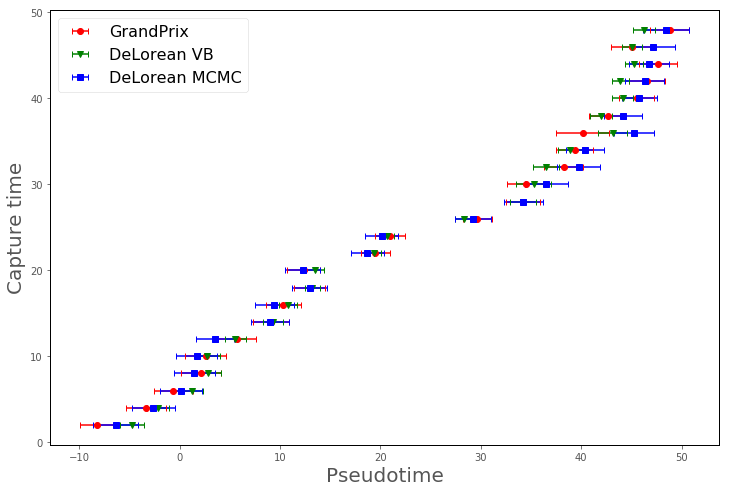

In [44]:
plt.figure(figsize=(12, 8))
plt.errorbar(pseudotime_rbf, actual_capture_time, xerr=2*np.sqrt(var_rbf), fmt='ro', capsize=3)
plt.errorbar(VB_rbf_best['tau'], actual_capture_time, xerr=2*np.sqrt(var_VB_rbf), fmt='gv', capsize=3)
plt.errorbar(MCMC_rbf_best['tau'], actual_capture_time, xerr=2*MCMCStdOnChains_rbf, fmt='bs', capsize=3)
plt.legend(['GrandPrix','DeLorean VB', 'DeLorean MCMC'],numpoints=1, loc=2, fontsize=16)
plt.xlabel('Pseudotime', fontsize=20)
plt.ylabel('Capture time', fontsize=20)

## Matern32 kernel

In [12]:
pseudotime_matern32, var_matern32 = GrandPrix.fit_model(Y, latent_prior_mean=prior_mean, latent_prior_var=np.square(sigma_t),
                             latent_mean=np.asarray(X_mean.copy()), latent_var=9,
                             kernel={'name':'Matern32', 'ls':18.0, 'var':1.0}, 
                             fix_parameters=['kernel_lengthscales','kernel_variance'], display=True)
# np.mean(np.sqrt(var_matern32))

sumon
Could not find signature for _expectation: <Gaussian, Matern32, NoneType, NoneType, NoneType>
Could not find signature for _expectation: <Gaussian, Matern32, InducingPoints, NoneType, NoneType>
Could not find signature for _expectation: <Gaussian, Matern32, InducingPoints, Matern32, InducingPoints>


/home/sumon/newInstall/GPflow/gpflow/expectations.py:110: UserWarning: Quadrature is used to calculate the expectation. This means that an analytical implementations is not available for the given combination.
  warnings.warn("Quadrature is used to calculate the expectation. This means that "


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2590.314829
  Number of iterations: 149
  Number of functions evaluations: 169


0.5487007672090536

### DeLorean ADVI

In [13]:
VB_matern32_best = pd.read_csv('../data/Windram/DeLorean_samples/Matern32/WindreamDeLorean_Matern32.csv', index_col=0)
VB_matern32 = pd.read_csv('../data/Windram/DeLorean_samples/Matern32/WindreamDeLoreanSamples_Matern32.csv', index_col=0)
var_VB_matern32 = VB_matern32.groupby('capture.orig')['tau'].var()
# np.mean(np.sqrt(var_VB_matern32))

0.41639017676782464

### DeLorean MCMC

In [14]:
MCMC_matern32_best = pd.read_csv('../data/Windram/DeLorean_samples/Matern32/WindreamDeLoreanBestSampleMCMC_Matern32.csv', index_col=0)
MCMC_matern32 = pd.read_csv('../data/Windram/DeLorean_samples/Matern32/WindreamDeLoreanSamplesMCMC_MultipleChains_Matern32.csv', index_col=0)

In [15]:
ncores = 11
MCMCStdEstimatesPerChain_matern32 = np.zeros((N, ncores))
for i in range(N):
    idx = MCMC_matern32.columns.str.contains('tau.%g.'%(i+1), regex=False)
    assert idx.sum() == ncores, 'should be %g chains per cell' % ncores
    MCMCStdEstimatesPerChain_matern32[i, :] = np.std(MCMC_matern32.iloc[:,idx], 0)
MCMCStdOnChains_matern32 = np.mean(MCMCStdEstimatesPerChain_matern32, 1)
# np.mean(MCMCStdOnChains_matern32)

0.932186908366556

Text(0.5,0,'Capture time')

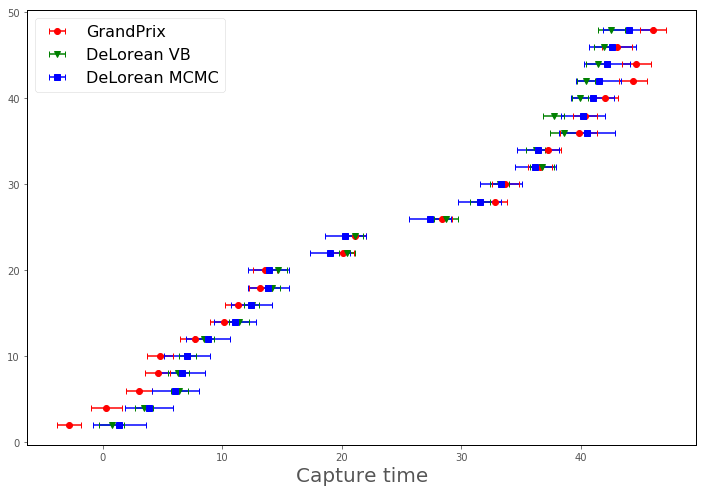

In [46]:
plt.figure(figsize=(12, 8))
plt.errorbar(pseudotime_matern32, actual_capture_time, xerr=2*np.sqrt(var_matern32), fmt='ro', capsize=3)
plt.errorbar(VB_matern32_best['tau'], actual_capture_time, xerr=2*np.sqrt(var_VB_matern32), fmt='gv', capsize=3)
plt.errorbar(MCMC_matern32_best['tau'], actual_capture_time, xerr=2*MCMCStdOnChains_matern32, fmt='bs', capsize=3)
plt.legend(['GrandPrix','DeLorean VB', 'DeLorean MCMC'],numpoints=1, loc=2, fontsize=16)
plt.xlabel('Pseudotime', fontsize=20)
plt.xlabel('Capture time', fontsize=20)

<Container object of 3 artists>

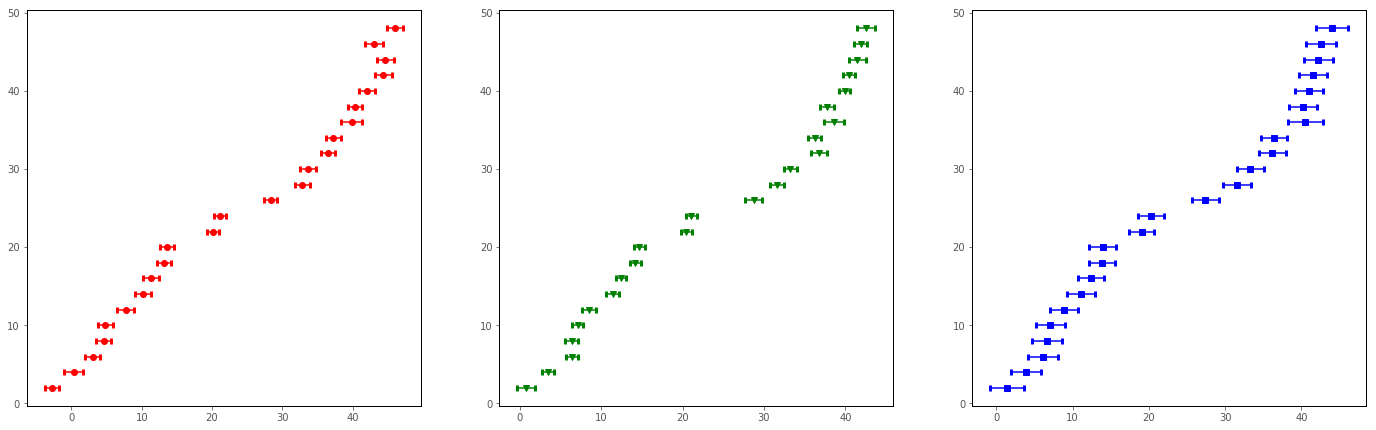

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(24, 16))
plt.subplot(2, 3, 1)
plt.errorbar(pseudotime_matern32, actual_capture_time, xerr=2*np.sqrt(var_matern32), fmt='ro', capsize=3, capthick=3)
plt.subplot(2, 3, 2)
plt.errorbar(VB_matern32_best['tau'], actual_capture_time, xerr=2*np.sqrt(var_VB_matern32), fmt='gv', capsize=3, capthick=3)
plt.subplot(2, 3, 3)
plt.errorbar(MCMC_matern32_best['tau'], actual_capture_time, xerr=2*MCMCStdOnChains_matern32, fmt='bs', capsize=3, capthick=3)

In [25]:
from beautifultable import BeautifulTable
table = BeautifulTable()

table.column_headers = ["Kernel name", "GrandPrix", "DeLorean VB", "DeLorean MCMC"]
table.append_row(["RBF", "%f"%(np.mean(np.sqrt(var_rbf))), "%f"%(np.mean(np.sqrt(var_VB_rbf))), "%f"%(np.mean(MCMCStdOnChains_rbf))])
table.append_row(["Matern32", "%f"%(np.mean(np.sqrt(var_matern32))), "%f"%(np.mean(np.sqrt(var_VB_matern32))), "%f"%(np.mean(MCMCStdOnChains_matern32))])

print(table)

+-------------+-----------+-------------+---------------+
| Kernel name | GrandPrix | DeLorean VB | DeLorean MCMC |
+-------------+-----------+-------------+---------------+
|     RBF     |   0.916   |    0.536    |     0.979     |
+-------------+-----------+-------------+---------------+
|  Matern32   |   0.549   |    0.416    |     0.932     |
+-------------+-----------+-------------+---------------+
